# 04. Lasso 회귀 적용

In [12]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
conn = pymysql.connect(host='localhost', user='ssafy', password='ssafy',
                       db='docong_test_v3', charset='utf8')
cursor = conn.cursor()

getPomoSql = f"SELECT user.seq, user.birth, user.gender, user.job, user.position, user.mbti, todo.work_importance, todo.predicted_pomo, todo.real_pomo, todo.work_proficiency, todo.work_type, pomo.start_time, pomo.end_time, pomo.time_status FROM pomodoro pomo LEFT JOIN todo ON pomo.todo_seq=todo.seq INNER JOIN user ON pomo.user_seq=user.seq WHERE todo.`status`=2;"
columns = ["user_seq", "birth","gender","job","position","mbti","importance","predicted_pomo", "real_pomo", "proficiency","type","start_time","end_time","timeStatus"]

cursor.execute(getPomoSql)
total = pd.DataFrame(cursor.fetchall(), columns=columns)
total.fillna(value=-1, inplace=True)
total.head()

,user_seq,birth,gender,job,position,mbti,importance,predicted_pomo,real_pomo,proficiency,type,start_time,end_time,timeStatus
0,2,1998-01-24T00:00:00.000Z,FEMALE,IT/인터넷,0,ISFP,4,12,20,1,4,2022-03-29 17:39:52,2022-03-29 17:54:52,SHORT
1,2,1998-01-24T00:00:00.000Z,FEMALE,IT/인터넷,0,ISFP,4,12,20,1,4,2022-03-29 21:07:02,2022-03-29 21:57:02,LONG
2,2,1998-01-24T00:00:00.000Z,FEMALE,IT/인터넷,0,ISFP,4,12,20,1,4,2022-03-29 22:19:53,2022-03-29 23:09:53,LONG
3,2,1998-01-24T00:00:00.000Z,FEMALE,IT/인터넷,0,ISFP,4,12,20,1,4,2022-03-29 23:17:30,2022-03-29 23:32:30,SHORT
4,2,1998-01-24T00:00:00.000Z,FEMALE,IT/인터넷,0,ISFP,4,12,20,1,4,2022-03-29 23:52:35,2022-03-30 00:17:35,BASIC


In [3]:
# birth -> 년/월/일 로 변경
total['birth_year'] = total.birth.str.split('-').str[0]
total['birth_month'] = total.birth.str.split('-').str[1]
total['birth_day'] = total.birth.str.split('-').str[2].str.split('T').str[0]
total.drop(['birth'], axis=1, inplace=True)

# 결측치는 0으로 채움
total['birth_year'].fillna(value=0, inplace=True)
total['birth_month'].fillna(value=0, inplace=True)
total['birth_day'].fillna(value=0, inplace=True)

total = total.astype({'birth_year': 'int', 'birth_month': 'int', 'birth_day': 'int'})


# gender
total['gender'] = total['gender'].map({'MALE': 0, 'FEMALE': 1, -1: -1})


# job
jobs = ['경영/사무', '마케팅/무역/유통', '영업/고객상담', 'IT/인터넷', '연구개발/설계',
        '생산/제조', '전문/특수직', '디자인', '미디어', '서비스', '건설']
map_dic = {-1: -1}
for i in range(len(jobs)):
    map_dic[jobs[i]] = i

total['job'] = total['job'].map(map_dic)


# mbti
mbtis = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 'ISTP', 'ISFP', 'INFP', 'INTP',
        'ESTP', 'ESFP', 'ENFP', 'ENTP', 'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ']
map_dic = {-1: -1}
for i in range(len(mbtis)):
    map_dic[mbtis[i]] = i

total['mbti'] = total['mbti'].map(map_dic)


# start_time, end_time

# 실행시간
def during_time(x):
    return x.total_seconds()

total['during_sec'] = (total['end_time'] - total['start_time']).apply(during_time)
total = total.astype({'during_sec': 'int'})

# 시간대
# 0 : 새벽 (24~4) 1: 아침(5~8) 2: 오전(9~11) 3: 오후(12~17) 4: 저녁(18~23)
bins = [-1, 4, 8, 11, 17, 23]
labels = [x for x in range(5)]

def hours(x):
    return x.hour

total['hours'] = total['start_time'].apply(hours)
cats = pd.cut(total['hours'], bins, labels=labels)
total['timezone'] = cats

total.drop(['start_time'], axis=1, inplace=True)
total.drop(['end_time'], axis=1, inplace=True)
total.drop(['hours'], axis=1, inplace=True)


# time_status

total['timeStatus'] = total['timeStatus'].map({
    'SHORT': 0, 'BASIC': 1,
    'LONG': 2, -1: -1
})


total.head()

,user_seq,gender,job,position,mbti,importance,predicted_pomo,real_pomo,proficiency,type,timeStatus,birth_year,birth_month,birth_day,during_sec,timezone
0,2,1,3,0,5,4,12,20,1,4,0,1998,1,24,900,3
1,2,1,3,0,5,4,12,20,1,4,2,1998,1,24,3000,4
2,2,1,3,0,5,4,12,20,1,4,2,1998,1,24,3000,4
3,2,1,3,0,5,4,12,20,1,4,0,1998,1,24,900,4
4,2,1,3,0,5,4,12,20,1,4,1,1998,1,24,1500,4


In [4]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   user_seq        213 non-null    int64   
 1   gender          213 non-null    int64   
 2   job             213 non-null    int64   
 3   position        213 non-null    object  
 4   mbti            213 non-null    int64   
 5   importance      213 non-null    int64   
 6   predicted_pomo  213 non-null    int64   
 7   real_pomo       213 non-null    int64   
 8   proficiency     213 non-null    int64   
 9   type            213 non-null    int64   
 10  timeStatus      213 non-null    int64   
 11  birth_year      213 non-null    int64   
 12  birth_month     213 non-null    int64   
 13  birth_day       213 non-null    int64   
 14  during_sec      213 non-null    int64   
 15  timezone        213 non-null    category
dtypes: category(1), int64(14), object(1)
memory usage: 25.5+ KB


In [5]:
total.describe()

,user_seq,gender,job,mbti,importance,predicted_pomo,real_pomo,proficiency,type,timeStatus,birth_year,birth_month,birth_day,during_sec
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,18.572770,0.352113,2.887324,5.638498,3.150235,8.084507,20.967136,1.089202,5.230047,1.028169,1939.478873,6.169014,16.676056,1812.690141
std,18.065933,0.534611,0.663381,5.183958,0.939672,4.013232,13.720383,1.084420,3.704744,0.800445,330.983078,3.881448,7.322313,880.086047
min,1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,4.000000,0.000000,3.000000,1.000000,2.000000,5.000000,8.000000,0.000000,4.000000,0.000000,1995.000000,1.000000,14.000000,900.000000
50%,25.000000,0.000000,3.000000,5.000000,4.000000,8.000000,20.000000,1.000000,4.000000,1.000000,1995.000000,7.000000,18.000000,1500.000000
75%,25.000000,1.000000,3.000000,10.000000,4.000000,12.000000,40.000000,2.000000,5.000000,2.000000,1996.000000,9.000000,20.000000,3000.000000
max,99.000000,1.000000,3.000000,15.000000,4.000000,12.000000,40.000000,4.000000,16.000000,2.000000,1998.000000,12.000000,28.000000,3000.000000


In [6]:
total.describe(include='O')

,position
count,213
unique,2
top,0
freq,207


## 전처리 후 예측

In [16]:
X, y = total.drop(['predicted_pomo', 'real_pomo'], axis=1), total.real_pomo
X_train, X_test, y_train, y_test = train_test_split(X, y)

lasso_model = Lasso(alpha=0.0001, max_iter=50000)
lasso_model.fit(X_train, y_train)

pred = lasso_model.predict(X_test)

print("훈련 세트 점수: {:.2f}".format(lasso_model.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(lasso_model.score(X_test, y_test)))

print(f'train_score: {cross_val_score(lasso_model, X_train, y_train, cv=5).mean()}')
print(f'test_score: {cross_val_score(lasso_model, X_test, y_test, cv=5).mean()}')

/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2116.5391261634513, tolerance: 3.073758490566036
  model = cd_fast.enet_coordinate_descent(


훈련 세트 점수: 0.85
테스트 세트 점수: 0.84


/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1723.5511897711617, tolerance: 2.5893984251968516
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 556.280678018127, tolerance: 2.3677606299212575
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1566.683353851592, tolerance: 2.4012157480314964
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want

train_score: 0.8020436875991004
test_score: 0.6936413808276856


/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678.2139774966313, tolerance: 2.45193046875
  model = cd_fast.enet_coordinate_descent(


In [17]:
data = {'y_test' : y_test, 'pred' : pred}
pd.DataFrame(data)

,y_test,pred
6,20,19.089548
123,5,6.202982
99,40,34.642879
86,40,33.803809
200,12,22.805635
107,40,34.972171
145,40,39.654162
193,20,23.749253
201,12,22.805635
113,21,18.428569


## 상관관계

In [14]:
total_corr = abs(total.corr())
total_corr['real_pomo'].sort_values(ascending=False).to_frame()

,real_pomo
real_pomo,1.000000
predicted_pomo,0.861070
proficiency,0.767331
mbti,0.620116
gender,0.503227
birth_month,0.450501
type,0.353783
birth_day,0.286251
job,0.206889
birth_year,0.205761


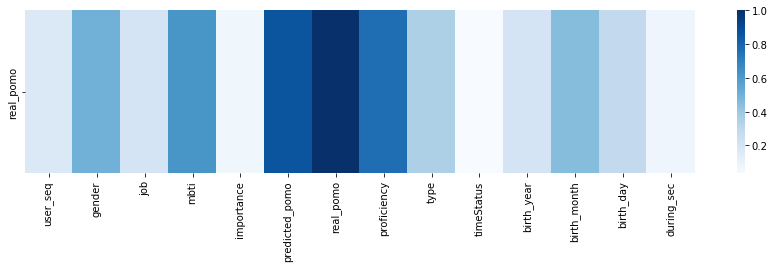

In [15]:
plt.figure(figsize=(15, 3))
sns.heatmap(total_corr.sort_values(by=['real_pomo'], ascending=False).head(1), cmap='Blues')
plt.show()

In [20]:
total_corr = abs(total.corr())
total_corr['during_sec'].sort_values(ascending=False).to_frame()

,during_sec
during_sec,1.000000
timeStatus,0.967694
importance,0.312550
birth_day,0.193871
birth_month,0.180800
user_seq,0.166760
mbti,0.118386
predicted_pomo,0.103063
type,0.097617
real_pomo,0.077029


## 상관관계 낮은 컬럼 삭제 후 예측

In [19]:
X, y = total.drop(['predicted_pomo', 'real_pomo', 'user_seq', 'importance', 'timeStatus'], axis=1), total.real_pomo
X_train, X_test, y_train, y_test = train_test_split(X, y)

lasso_model = Lasso(alpha=0.0001, max_iter=50000)
lasso_model.fit(X_train, y_train)

pred = lasso_model.predict(X_test)

print("훈련 세트 점수: {:.2f}".format(lasso_model.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(lasso_model.score(X_test, y_test)))

print(f'train_score: {cross_val_score(lasso_model, X_train, y_train, cv=5).mean()}')
print(f'test_score: {cross_val_score(lasso_model, X_test, y_test, cv=5).mean()}')

/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2511.510238961952, tolerance: 2.931084276729558
  model = cd_fast.enet_coordinate_descent(


훈련 세트 점수: 0.81
테스트 세트 점수: 0.82


/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1457.737667127703, tolerance: 2.2611732283464567
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1896.0828591642253, tolerance: 2.4004377952755886
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1957.5883479243323, tolerance: 2.362407874015751
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might wan

train_score: 0.7511667991003877
test_score: 0.7368553959446016


/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.79980120272734, tolerance: 0.8256279069767445
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.63555245244726, tolerance: 0.9278418604651163
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.9525495591752, tolerance: 0.8848636363636364
  model = cd_fast.enet_coordinate_descent(


## 시각화

In [21]:
visual_data = total.drop(['predicted_pomo', 'user_seq', 'importance', 'timeStatus'], axis=1)

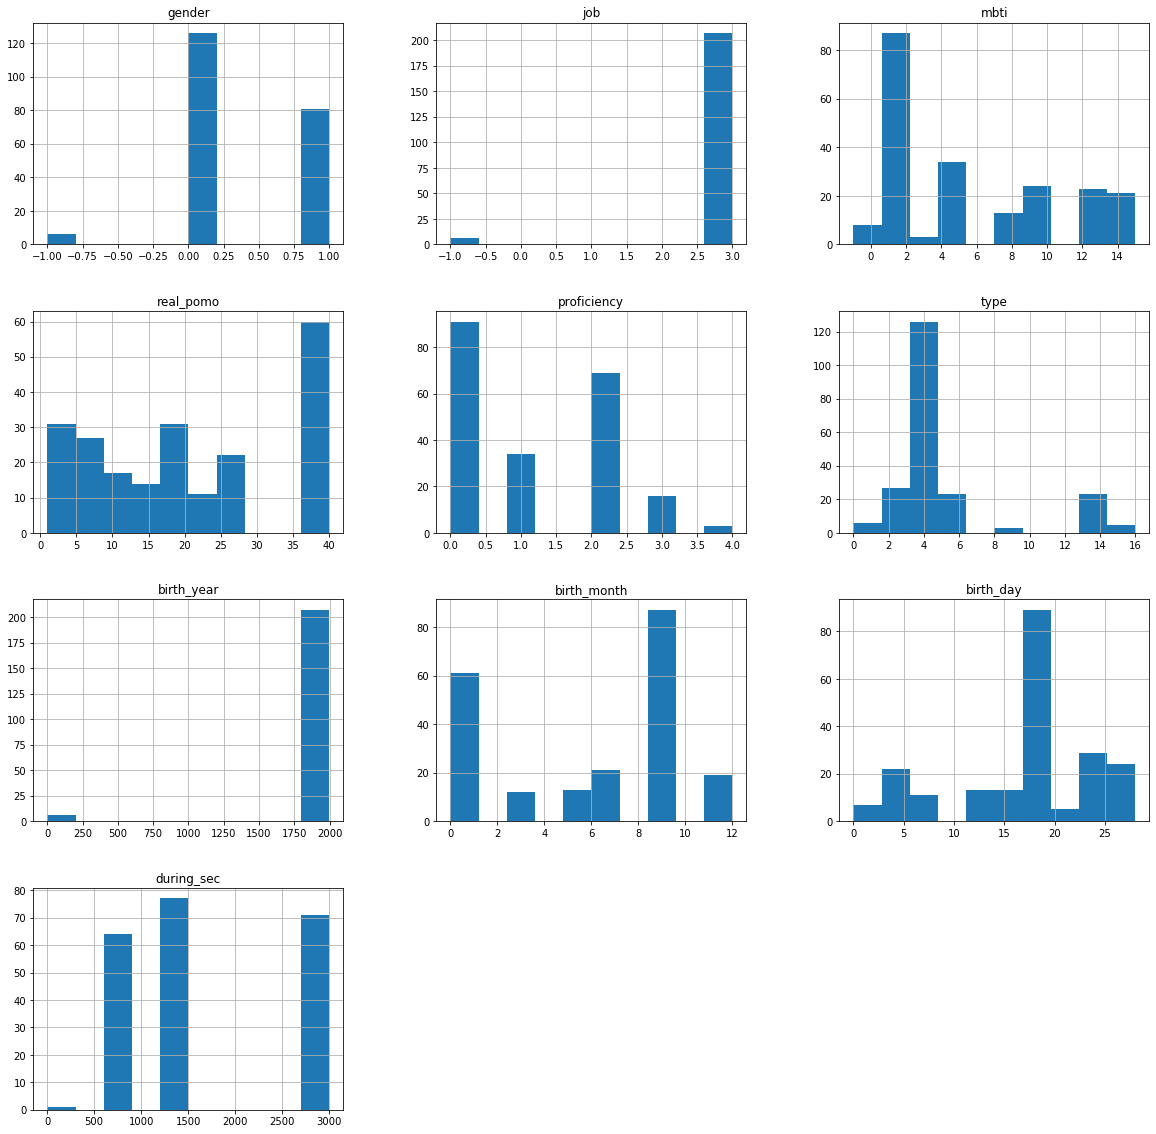

In [22]:
visual_data.hist(bins=10, figsize=(20, 20,)) # bins : 구간 개수
plt.show()

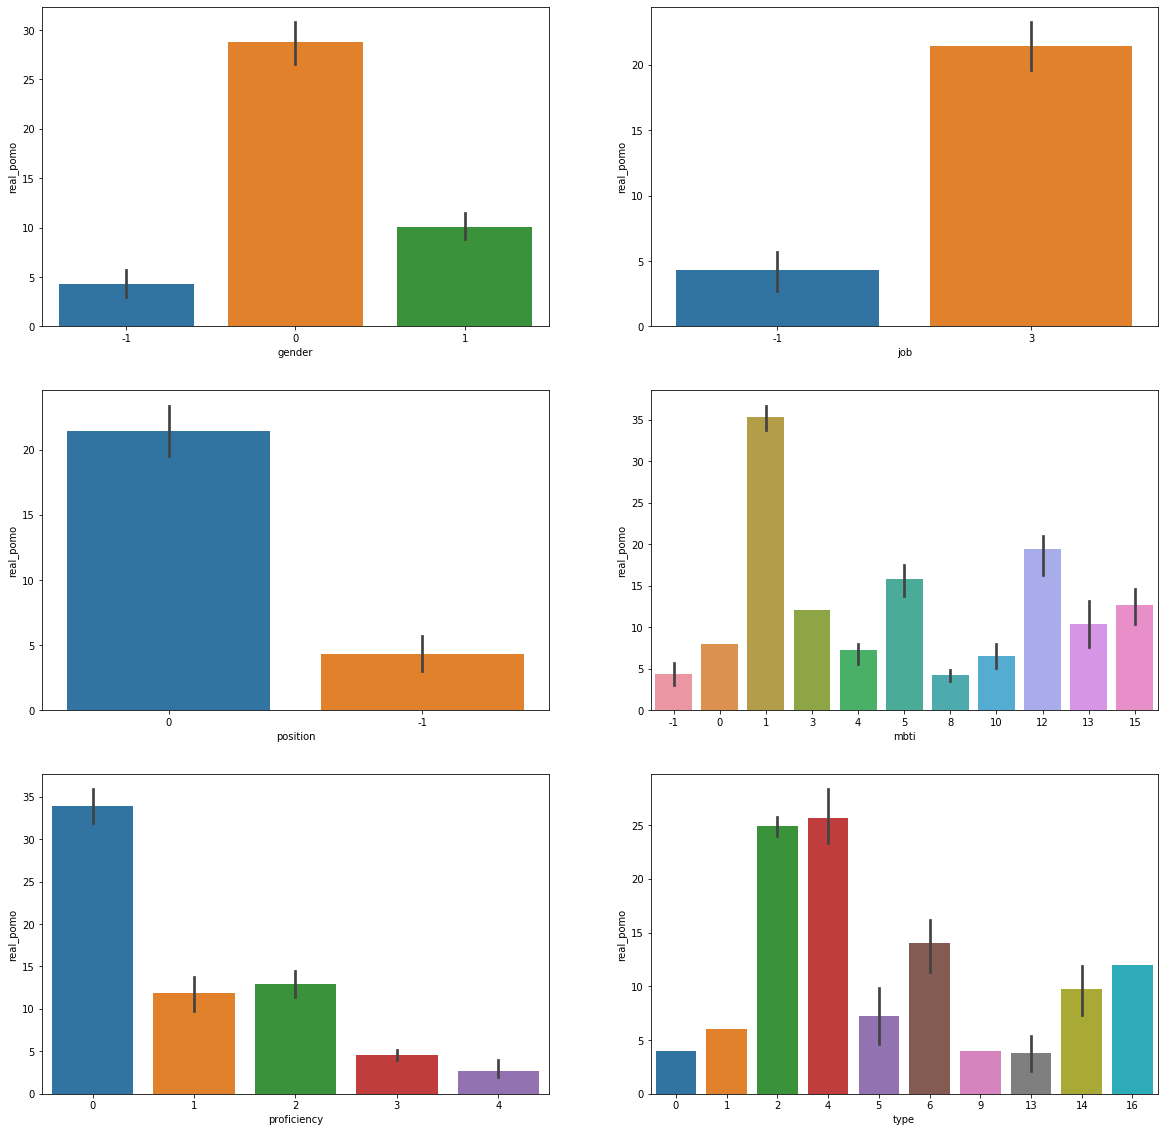

In [40]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(20, 20)

sns.barplot(data=visual_data, x='gender', y='real_pomo', ax=ax1)
sns.barplot(data=visual_data, x='job', y='real_pomo', ax=ax2)
sns.barplot(data=visual_data, x='position', y='real_pomo', ax=ax3)
sns.barplot(data=visual_data, x='mbti', y='real_pomo', ax=ax4)
sns.barplot(data=visual_data, x='proficiency', y='real_pomo', ax=ax5)
sns.barplot(data=visual_data, x='type', y='real_pomo', ax=ax6)

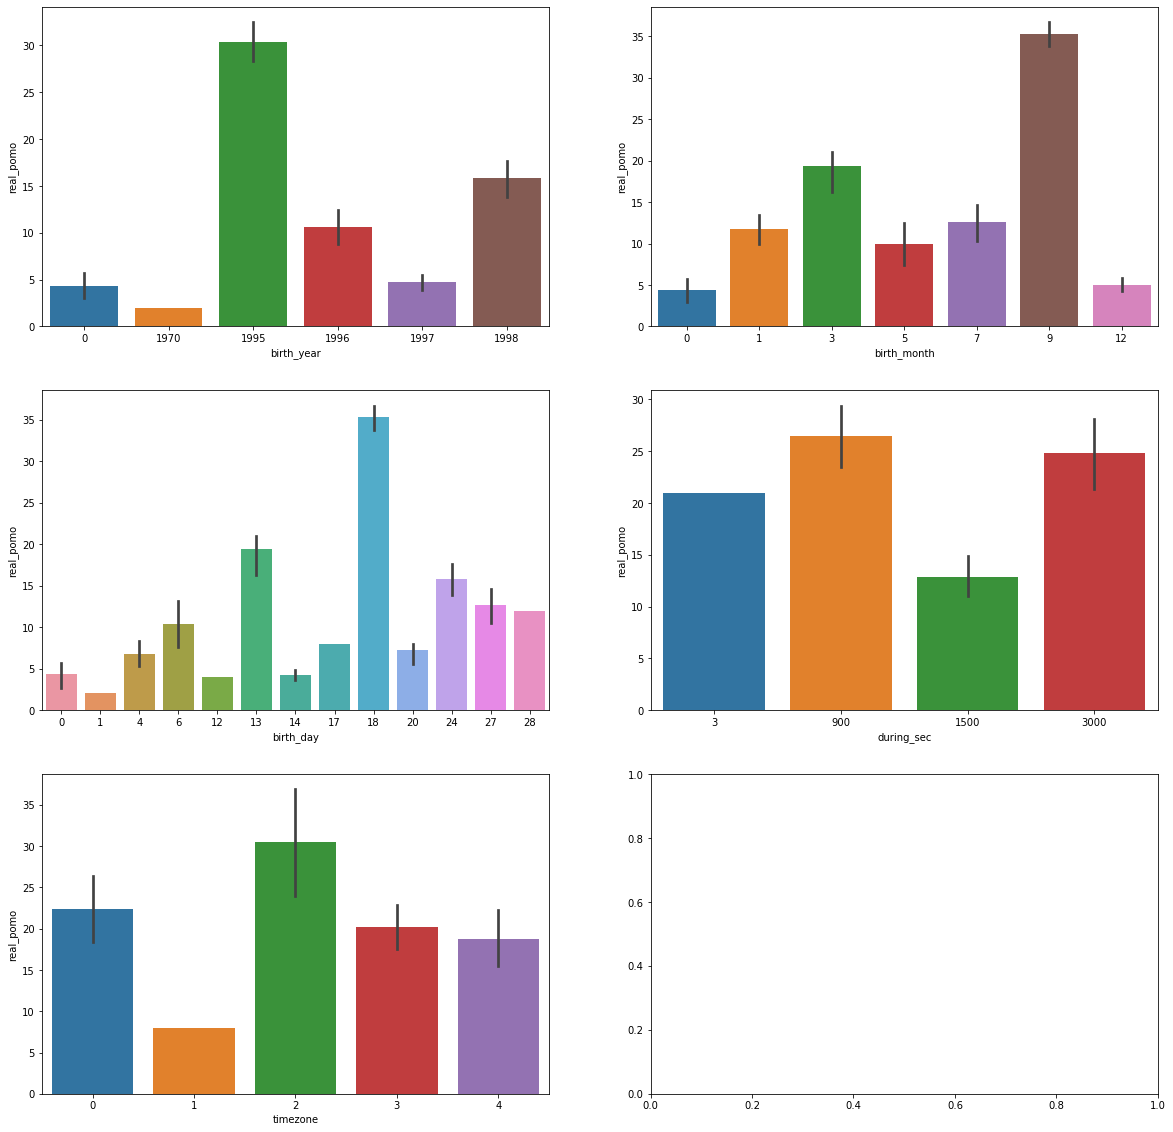

In [41]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(20, 20)

sns.barplot(data=visual_data, x='birth_year', y='real_pomo', ax=ax1)
sns.barplot(data=visual_data, x='birth_month', y='real_pomo', ax=ax2)
sns.barplot(data=visual_data, x='birth_day', y='real_pomo', ax=ax3)
sns.barplot(data=visual_data, x='during_sec', y='real_pomo', ax=ax4)
sns.barplot(data=visual_data, x='timezone', y='real_pomo', ax=ax5)